In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [2]:
if len(tf.config.list_physical_devices('GPU')):
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Loading data

In [119]:
dataset = pd.read_csv("train_data", index_col=0)

In [120]:
dataset = dataset.dropna()

In [121]:
dataset = (dataset[(dataset.lang=="en")]).reset_index(drop=True).sort_index()

In [122]:
smallest_amount_data = min(dataset.priceChangeClass.value_counts())

indexes = []
for unique_class in set(dataset.priceChangeClass):
        temp_indexes = dataset.loc[dataset.priceChangeClass==unique_class].sample(smallest_amount_data).index
        #print(list(temp_indexes))
        indexes += list(temp_indexes)
# Pick out indexes, shuffle rows, and reset indexes
balanced_dataset = dataset.loc[indexes].sample(frac=1).reset_index(drop=True)

In [123]:
balanced_dataset

,datetime,headline,summary,related,lang,source,priceChangeClass
0,2020-02-18 01:15:25-05:00,Adelaide Holden dealer was due to open $6.5M s...,A Holden car dealership had been gearing up to...,GM,en,Daily Mail Online,0
1,2020-04-17 01:00:27-05:00,COVID-19 impact roundup: How Hyatt is demonstr...,Despite occupancy rates lower than those durin...,H,en,Top Hotels News,0
2,2020-02-12 03:06:59-05:00,Harry 'in talks with Goldman Sachs' after bein...,The Duke of Sussex and wife Meghan Markle are ...,GS,en,Birmingham Live,2
3,2020-04-24 07:16:00-05:00,What to Expect For 3M Company (MMM) This Earni...,3M Company's (MMM) first-quarter 2020 results ...,MMM,en,Zacks Investment Research,2
4,2020-08-04 07:30:00-05:00,Caroline Levy Appointed to Board of Directors ...,"BOCA RATON, Fla., Aug. 4, 2020 /PRNewswire/ --...",SE,en,PR Newswire,0
...,...,...,...,...,...,...,...
195694,2019-02-19 16:38:41-05:00,"American Water Works EPS in-line, misses on re...",No summary available.,AWK,en,Seeking Alpha,0
195695,2019-12-16 11:05:00-05:00,Angola: Total Acquires Interests into Two New ...,PARIS--(BUSINESS WIRE)--Regulatory News: TOTAL...,BP,en,Business Wire,1
195696,2020-03-10 12:26:55-05:00,Cenovus spending cut expected to set trend as ...,Analysts expect to see lower Canadian oil prod...,CVE,en,CTV News,2
195697,2020-10-14 11:29:38-05:00,FXNEWS24 |Is Nu Skin Enterprises (NUS) Stock O...,Is Nu Skin Enterprises (NUS) Stock Outpacing I...,NUS,en,FXNews24,2


In [124]:
#TODO: remove 
dataset = balanced_dataset.sample(n=50000).reset_index(drop=True).sort_index()
dataset

,datetime,headline,summary,related,lang,source,priceChangeClass
0,2020-09-08 07:57:00-05:00,HanesBrands Appoints Kristin L. Oliver as Chie...,"WINSTON-SALEM, N.C.--(BUSINESS WIRE)--Kristin ...",HBI,en,Business Wire,0
1,2020-09-08 09:42:50-05:00,Nikola & GM challenge Tesla with world’s ‘most...,The electric truck startup Nikola and General ...,GM,en,Russia Today,2
2,2019-11-04 03:00:00-05:00,Business Breakfast LIVE: McDonald's CEO steps ...,The BusinessLive team's blog bringing you the ...,MCD,en,Business Live,0
3,2020-06-02 09:00:00-05:00,PCI EIM Enterprise Cloud Platform Selected by ...,"NORMAN, Okla.--(BUSINESS WIRE)-- #pciplatform-...",AVA,en,Business Wire,2
4,2020-03-10 10:07:53-05:00,BUY NCR Corporation (NCR): Undervalued stock w...,The Broad Market Index was down 11.49% last we...,NCR,en,ValueWalk,2
...,...,...,...,...,...,...,...
49995,2020-01-02 09:00:00-05:00,Cigna Corporation Announces Appearance at the ...,"BLOOMFIELD, Conn., Jan. 2, 2020 /PRNewswire/ -...",CI,en,PR Newswire,1
49996,2019-07-31 07:55:09-05:00,Clean Harbors (CLH) Surpasses Q2 Earnings Esti...,Clean Harbors (CLH) delivered earnings and rev...,CLH,en,Zacks Investment Research,2
49997,2019-12-22 13:00:00-05:00,Adam Schiff Has 'No Sympathy' For FBI Victim C...,Adam Schiff Has 'No Sympathy' For FBI Victim C...,CIA,en,Zero Hedge,0
49998,2020-07-20 07:00:00-05:00,Taxing billionaires would be a great way to fu...,The idea of taxing the ultra-wealthy to cover ...,TWTR,en,Business Insider,2


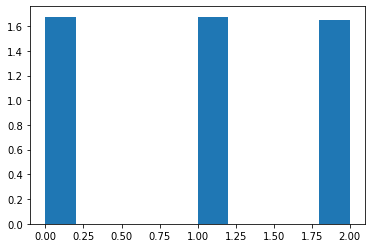

In [125]:
plt.hist(dataset.priceChangeClass, density=True)
plt.show()

In [126]:
seed = 12345

val_percent = 0.1
test_percent = 0.2

validation_data = (dataset.sample(frac=val_percent, random_state=seed)).reset_index(drop=True)
test_data = (dataset.sample(frac=test_percent, random_state=seed)).reset_index(drop=True)
train_data = (dataset.iloc[dataset.index.difference(test_data.index).difference(validation_data.index)]).reset_index(drop=True)

In [127]:
train_data

,datetime,headline,summary,related,lang,source,priceChangeClass
0,2020-05-31 02:15:05-05:00,"In a polarised world, even checking facts on T...",Trump wants to stifle critics. But his battle ...,TWTR,en,The Guardian,0
1,2020-11-04 11:11:43-05:00,Sanmar Shipyards and SCHOTTEL strengthen colla...,Press Release – Sanmar Shipyards and the Germa...,BP,en,gCaptain,1
2,2019-11-20 12:53:27-05:00,GM files racketeering suit against Fiat Chrysl...,General Motors is suing Fiat Chrysler Automobi...,"FCA,FCAU",en,USA Today,0
3,2020-05-16 12:00:00-05:00,Here Is What Hedge Funds Bought And Sold In Th...,Here Is What Hedge Funds Bought And Sold In Th...,DPZ,en,Zero Hedge,2
4,2020-02-03 05:05:00-05:00,Most Watched Sporting Event Translates to a Bi...,"CHICAGO, Feb. 3, 2020 /PRNewswire/ -- The Big ...",CARS,en,PR Newswire,2
...,...,...,...,...,...,...,...
39995,2020-01-02 09:00:00-05:00,Cigna Corporation Announces Appearance at the ...,"BLOOMFIELD, Conn., Jan. 2, 2020 /PRNewswire/ -...",CI,en,PR Newswire,1
39996,2019-07-31 07:55:09-05:00,Clean Harbors (CLH) Surpasses Q2 Earnings Esti...,Clean Harbors (CLH) delivered earnings and rev...,CLH,en,Zacks Investment Research,2
39997,2019-12-22 13:00:00-05:00,Adam Schiff Has 'No Sympathy' For FBI Victim C...,Adam Schiff Has 'No Sympathy' For FBI Victim C...,CIA,en,Zero Hedge,0
39998,2020-07-20 07:00:00-05:00,Taxing billionaires would be a great way to fu...,The idea of taxing the ultra-wealthy to cover ...,TWTR,en,Business Insider,2


## Loading bert model and preprocessor

In [128]:
small_bert_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
small_bert_preprocessor = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2"

#TODO: fix sequence length?
bert_preprocess_model = hub.KerasLayer(small_bert_preprocessor)
bert_model = hub.KerasLayer(small_bert_url)

### Preprocess some text

In [129]:
test_text = ["ValuEngine upgraded shares of Skechers USA (NYSE:SKX) from a hold rating to a buy rating in a research note issued to investors on Saturday morning, ValuEngine reports. SKX has been the topic of several other reports. 140166 increased their price objective on Skechers USA from $32.00 to $39.00 in a research report on Friday, July"]

text_preprocessed = bert_preprocess_model(test_text)
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"]}')
print(f'Input Mask : {text_preprocessed["input_mask"]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [[  101  3643  3070  3170  9725  6661  1997 15315 27635  2869  3915  1006
   6396  3366  1024 15315  2595  1007  2013  1037  2907  5790  2000  1037
   4965  5790  1999  1037  2470  3602  3843  2000  9387  2006  5095  2851
   1010  3643  3070  3170  4311  1012 15315  2595  2038  2042  1996  8476
   1997  2195  2060  4311  1012  8574 16048  2575  3445  2037  3976  7863
   2006 15315 27635  2869  3915  2013  1002  3590  1012  4002  2000  1002
   4464  1012  4002  1999  1037  2470  3189  2006  5958  1010  2251   102
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]]
Input Mask : [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 

In [130]:
bert_results = bert_model(text_preprocessed)

print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9824908   0.76062226 -0.03692193  0.12203462  0.39114746  0.41416568
  0.9954358  -0.89795995 -0.38491482 -0.9893756  -0.20844996 -0.6297051 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.43924457 -0.13059938  0.90825254 ... -0.8680172   0.5541188
   0.8547666 ]
 [-0.23845711 -0.5364785   0.29254144 ... -0.39248142  0.74903923
  -0.4524054 ]
 [-0.4771736   0.39477485 -0.3236331  ... -0.69937664 -0.07088979
  -0.21797672]
 ...
 [-0.90205806  1.7535473   0.75899905 ... -0.6645514   0.48757368
   0.9621246 ]
 [-0.07816001  0.5708613   0.01111203 ... -0.34754694  0.8900679
   0.82887846]
 [-0.132772   -0.16776928 -0.7433138  ... -0.43809432  0.09481239
   0.6366134 ]]


In [131]:
def create_classifier_model():
    text_input_layer = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
    preprocessing_layer = hub.KerasLayer(small_bert_preprocessor, name="preprocessor")
    encoded_input = preprocessing_layer(text_input_layer)
    encoder = hub.KerasLayer(small_bert_url, trainable=True, name="bert_encoder")
    outputs = encoder(encoded_input)
    net = outputs["pooled_output"]
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(3, activation=None, name="classifier")(net)
    return tf.keras.Model(text_input_layer, net)

In [132]:
classifier_model = create_classifier_model()
bert_raw_result = classifier_model(tf.constant(test_text))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.49317273 0.37619567 0.48249152]], shape=(1, 3), dtype=float32)


In [133]:
tf.keras.utils.plot_model(classifier_model)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [134]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.metrics.CategoricalAccuracy()

In [143]:
epochs = 2
steps_per_epoch = len(train_data.index)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [142]:
classifier_model.compile(optimizer=optimizer,
                        loss=loss_function,
                        metrics=metric)

In [140]:
x_train = np.array(train_data.headline)
y_train = np.array(train_data.priceChangeClass).astype(np.int8)

#x_train = x_train[:50000]
#y_train = y_train[:50000]

#x_train
classifier_model.fit(x_train, y_train, batch_size=8)
#y_train

3806/5000 [=====================>........] - ETA: 1:44 - loss: 1.1023 - categorical_accuracy: 0.0949

ResourceExhaustedError:  OOM when allocating tensor with shape[30522,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node AdamWeightDecay/AdamWeightDecay/update/AssignVariableOp (defined at /home/hugo/.local/lib/python3.8/site-packages/official/nlp/optimization.py:204) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_330993]

Function call stack:
train_function


In [141]:

test_x = np.array(test_data.headline)
test_y = np.array(test_data.priceChangeClass).astype(np.int8)

res = classifier_model.predict(test_x)

KeyboardInterrupt: 

In [115]:
#tf.math.confusion_matrix(labels=test_y, predictions=res)

rez = []
for elem in res:
    aa = tf.math.argmax(elem)
    rez.append(aa.numpy())

In [116]:
tf.math.confusion_matrix(labels=test_y, predictions=rez)

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[  12, 1587,  474],
       [  48, 4158, 1254],
       [  23, 1874,  570]], dtype=int32)>

In [ ]:
m = tf.keras.metrics.Accuracy()
m.update_state(rez, test_y)
m.result().numpy()

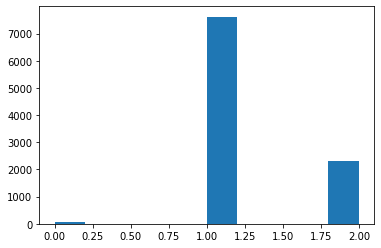

In [117]:
plt.hist(rez)
plt.show()

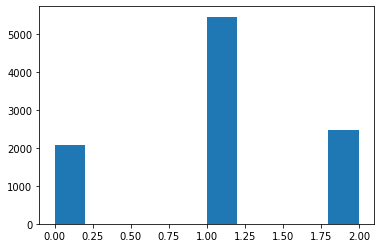

In [118]:
plt.hist(test_y)
plt.show()

In [32]:
train_data

,index,datetime,headline,summary,related,lang,source,priceChangeClass
0,70899,2020-10-19 21:03:14-05:00,Skechers USA (NYSE:SKX) Lifted to “Buy” at Val...,ValuEngine upgraded shares of Skechers USA (NY...,SKX,en,Stock Observer,1
1,70900,2020-10-08 15:05:00-05:00,"SKECHERS USA, Inc. to Report Third Quarter 202...","MANHATTAN BEACH, Calif.--(BUSINESS WIRE)--SKEC...",SKX,en,Business Wire,0
2,70901,2020-10-02 01:00:00-05:00,Footwear Market will Showcase Negative Impact ...,Technavio has been monitoring the footwear mar...,SKX,en,Benzinga,0
3,70902,2020-09-24 14:27:56-05:00,Jon Najarian Sees Unusual Options Activity In ...,"On CNBC's ""Fast Money Halftime Report,"" Jon Na...",SKX,en,Benzinga,1
4,70903,2020-09-02 15:05:00-05:00,Skechers Announces Virtual Participation at th...,"MANHATTAN BEACH, Calif.--(BUSINESS WIRE)--SKEC...",SKX,en,Business Wire,1
...,...,...,...,...,...,...,...,...
283591,354490,2019-02-19 13:08:09-05:00,"Advance Auto Parts, Inc. (AAP) CEO Tom Greco o...",No summary available.,AAP,en,Seeking Alpha,1
283592,354491,2019-02-19 06:50:47-05:00,Advance Auto Parts lower post Q4 results,No summary available.,AAP,en,Seeking Alpha,0
283593,354492,2019-02-19 06:42:14-05:00,Advance Auto Parts declares $0.06 dividend,No summary available.,AAP,en,Seeking Alpha,0
283594,354493,2019-02-19 06:40:42-05:00,"Advance Auto Parts beats by $0.04, revenue in-...",No summary available.,AAP,en,Seeking Alpha,0
